# GoogleNet Branching Analysis

## Import Packages

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.linalg
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
import torchvision
from cca_core import flatten_weights
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import pandas as pd
import pickle
import os
from numpy.linalg import LinAlgError



## Style Settings

In [2]:
# Set color palettes
dark_green = '#006400'
dark_red = '#8b0000'
pal = {'Trained': dark_green, 'Untrained': dark_red}
light_green = '#90ee90'
light_red = '#ffcccb'
face_palette = sns.color_palette([light_green, light_red])

# Increase font size and thickness of axes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.linewidth': 2,
    'xtick.major.width': 2.5,
    'ytick.major.width': 2.5,
    'xtick.minor.width': 2,
    'ytick.minor.width': 2,
    'xtick.major.size': 10,
    'ytick.major.size': 10,
    'xtick.minor.size': 5,
    'ytick.minor.size': 5
})


## Import Models and weights

In [3]:
# Load GoogLeNet with specific pretrained weights
weights = 'GoogLeNet_Weights.IMAGENET1K_V1'
googlenet = torchvision.models.googlenet(weights=weights)
googlenet_untrained = torchvision.models.googlenet(weights=None)
googlenet.eval()
googlenet_untrained.eval()

/opt/miniconda3/envs/allen/lib/python3.10/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [4]:
# grab the weights from the modules
weights = []
# Use named_modules() to get both names and modules
for name, module in googlenet.named_modules():
    if isinstance(module, torch.nn.Conv2d):  # Check if the module is a Conv2d layer
        weights.append(module.weight.data.cpu().numpy())  # Append the numpy array of weights
        # print(f"Layer Name: {name}, Weight Shape: {module.weight.shape}")

In [5]:
# print named modules 
for name, module in googlenet.named_modules():
    print(name)


conv1
conv1.conv
conv1.bn
maxpool1
conv2
conv2.conv
conv2.bn
conv3
conv3.conv
conv3.bn
maxpool2
inception3a
inception3a.branch1
inception3a.branch1.conv
inception3a.branch1.bn
inception3a.branch2
inception3a.branch2.0
inception3a.branch2.0.conv
inception3a.branch2.0.bn
inception3a.branch2.1
inception3a.branch2.1.conv
inception3a.branch2.1.bn
inception3a.branch3
inception3a.branch3.0
inception3a.branch3.0.conv
inception3a.branch3.0.bn
inception3a.branch3.1
inception3a.branch3.1.conv
inception3a.branch3.1.bn
inception3a.branch4
inception3a.branch4.0
inception3a.branch4.1
inception3a.branch4.1.conv
inception3a.branch4.1.bn
inception3b
inception3b.branch1
inception3b.branch1.conv
inception3b.branch1.bn
inception3b.branch2
inception3b.branch2.0
inception3b.branch2.0.conv
inception3b.branch2.0.bn
inception3b.branch2.1
inception3b.branch2.1.conv
inception3b.branch2.1.bn
inception3b.branch3
inception3b.branch3.0
inception3b.branch3.0.conv
inception3b.branch3.0.bn
inception3b.branch3.1
incepti

In [6]:
def unfold_weights(conv_layer, weight):
    out_channels, in_channels, kernel_height, kernel_width = conv_layer.weight.shape
    
    unfold = nn.Unfold(kernel_size=(kernel_height, kernel_width),
                       dilation=conv_layer.dilation,
                       padding=0,
                       stride=1)
    
    # Convert weight back to a PyTorch tensor if it's a NumPy array
    if isinstance(weight, np.ndarray):
        weight = torch.from_numpy(weight)
    
    # Apply unfold
    unfolded = unfold(weight)
    unfolded = unfolded.view(out_channels, -1).cpu().numpy() 
    # print(f'Unfolded shape: {unfolded.shape}')
    # Reshape the result
    return unfolded

def extract_and_flatten_weights(module, branches):
    weights = {}
    for branch in branches:
        if branch == 'branch1':
            conv_layer = module._modules[branch].conv
        else:
            conv_layer = module._modules[branch][0].conv
        
        weight = conv_layer.weight.data.clone().detach().cpu().numpy()
        weights[branch] = unfold_weights(conv_layer, weight)
    return weights

In [7]:

# Define the branches of interest
branches = ['branch1', 'branch2', 'branch3']

# Extract and flatten weights for each Inception module
inception_modules = ['inception3a', 'inception3b', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'inception5a', 'inception5b']
all_weights_trained = {}
all_weights_untrained = {}

for module_name in inception_modules:
    module = getattr(googlenet, module_name)
    all_weights_trained[module_name] = extract_and_flatten_weights(module, branches)
    # Assuming the untrained model is defined as `googlenet_untrained`
    module_untrained = getattr(googlenet_untrained, module_name)
    all_weights_untrained[module_name] = extract_and_flatten_weights(module_untrained, branches)

In [8]:
# for each inception module, grab the first convolutional layer of the first three branches and flatten the weights
# Dictionary to store the convolutional weights with module and branch names
all_conv_weights = {}

# Iterate through each inception module
for module_name in ['3a', '3b', '4a', '4b', '4c', '4d', '4e', '5a', '5b']:
    module = getattr(googlenet, f'inception{module_name}')
    
    # Handle branch1 separately
    branch1_conv_weights = module.branch1.conv.weight.data.clone().detach().cpu().numpy()
    print(f'Inception{module_name} branch1 conv1 weights shape:', branch1_conv_weights.shape)
    all_conv_weights[f'inception{module_name}_branch1_conv1'] = branch1_conv_weights
    
    # Handle branch2, branch3, using indexing
    for branch_idx in range(2, 4):
        branch_name = f'branch{branch_idx}'
        if hasattr(module, branch_name):
            branch = getattr(module, branch_name)
            conv_weights = branch[0].conv.weight.data.clone().detach().cpu().numpy()
            print(f'Inception{module_name} {branch_name} conv1 weights shape:', conv_weights.shape)
            all_conv_weights[f'inception{module_name}_{branch_name}_conv1'] = conv_weights

# do the same for the untrained model
# Dictionary to store the convolutional weights with module and branch names
all_conv_weights_untrained = {}

# Iterate through each inception module
for module_name in ['3a', '3b', '4a', '4b', '4c', '4d', '4e', '5a', '5b']:
    module = getattr(googlenet_untrained, f'inception{module_name}')
    
    # Handle branch1 separately
    branch1_conv_weights = module.branch1.conv.weight.data.clone().detach().cpu().numpy()
    print(f'Inception{module_name} branch1 conv1 weights shape:', branch1_conv_weights.shape)
    all_conv_weights_untrained[f'inception{module_name}_branch1_conv1'] = branch1_conv_weights
    
    # Handle branch2, branch3, using indexing
    for branch_idx in range(2, 4):
        branch_name = f'branch{branch_idx}'
        if hasattr(module, branch_name):
            branch = getattr(module, branch_name)
            conv_weights = branch[0].conv.weight.data.clone().detach().cpu().numpy()
            print(f'Inception{module_name} {branch_name} conv1 weights shape:', conv_weights.shape)
            all_conv_weights_untrained[f'inception{module_name}_{branch_name}_conv1'] = conv_weights


Inception3a branch1 conv1 weights shape: (64, 192, 1, 1)
Inception3a branch2 conv1 weights shape: (96, 192, 1, 1)
Inception3a branch3 conv1 weights shape: (16, 192, 1, 1)
Inception3b branch1 conv1 weights shape: (128, 256, 1, 1)
Inception3b branch2 conv1 weights shape: (128, 256, 1, 1)
Inception3b branch3 conv1 weights shape: (32, 256, 1, 1)
Inception4a branch1 conv1 weights shape: (192, 480, 1, 1)
Inception4a branch2 conv1 weights shape: (96, 480, 1, 1)
Inception4a branch3 conv1 weights shape: (16, 480, 1, 1)
Inception4b branch1 conv1 weights shape: (160, 512, 1, 1)
Inception4b branch2 conv1 weights shape: (112, 512, 1, 1)
Inception4b branch3 conv1 weights shape: (24, 512, 1, 1)
Inception4c branch1 conv1 weights shape: (128, 512, 1, 1)
Inception4c branch2 conv1 weights shape: (128, 512, 1, 1)
Inception4c branch3 conv1 weights shape: (24, 512, 1, 1)
Inception4d branch1 conv1 weights shape: (112, 512, 1, 1)
Inception4d branch2 conv1 weights shape: (144, 512, 1, 1)
Inception4d branch3 co

In [9]:
# create subspace function to calculate the subspace angles between the V matrices
def subspace_angles_function(V1, V2):
    angles = []
    # truncate the number of rows to match the smaller matrix
    min_rows = min(V1.shape[0], V2.shape[0])
    V1 = V1[:min_rows, :]
    V2 = V2[:min_rows, :]
    angles = np.degrees(subspace_angles(V1, V2))
    return angles

In [10]:
# Define the branches of interest
branches = ['branch1', 'branch2', 'branch3']

# Extract and flatten weights for each Inception module
inception_modules = ['inception3a', 'inception3b', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'inception5a', 'inception5b']
all_weights_trained = {}
all_weights_untrained = {}

for module_name in inception_modules:
    module = getattr(googlenet, module_name)
    all_weights_trained[module_name] = extract_and_flatten_weights(module, branches)
    # Assuming the untrained model is defined as `googlenet_untrained`
    module_untrained = getattr(googlenet_untrained, module_name)
    all_weights_untrained[module_name] = extract_and_flatten_weights(module_untrained, branches)

# Perform SVD on the flattened weights and compute subspace angles
subspace_angles_trained = {}
subspace_angles_untrained = {}

for module_name, weights in all_weights_trained.items():
    # Perform SVD on the trained weights
    U1, S1, V1 = np.linalg.svd(weights['branch1'], full_matrices=False)
    U2, S2, V2 = np.linalg.svd(weights['branch2'], full_matrices=False)
    U3, S3, V3 = np.linalg.svd(weights['branch3'], full_matrices=False)
    V1 = V1.T
    V2 = V2.T
    V3 = V3.T

    # Perform SVD on the untrained weights
    weights_untrained = all_weights_untrained[module_name]
    U1_untrained, S1_untrained, V1_untrained = np.linalg.svd(weights_untrained['branch1'], full_matrices=False)
    U2_untrained, S2_untrained, V2_untrained = np.linalg.svd(weights_untrained['branch2'], full_matrices=False)
    U3_untrained, S3_untrained, V3_untrained = np.linalg.svd(weights_untrained['branch3'], full_matrices=False)
    V1_untrained = V1_untrained.T
    V2_untrained = V2_untrained.T
    V3_untrained = V3_untrained.T

    # Compute subspace angles for trained
    subspace_angles_trained[module_name] = [subspace_angles_function(V1, V2), subspace_angles_function(V1, V3), subspace_angles_function(V2, V3)]

    # Compute subspace angles for untrained
    subspace_angles_untrained[module_name] = [subspace_angles_function(V1_untrained, V2_untrained), subspace_angles_function(V1_untrained, V3_untrained), subspace_angles_function(V2_untrained, V3_untrained)]

In [11]:

# # Directory where pickle files will be stored
# pickle_folder = 'pickle'

# # Ensure the pickle folder exists, create if it doesn't
# os.makedirs(pickle_folder, exist_ok=True)

# # Save trained and untrained angles dictionaries to pickle files in the pickle folder
# with open(os.path.join(pickle_folder, 'trained_angles_inception_branches.pkl'), 'wb') as f:
#     pickle.dump(subspace_angles_trained, f)

# with open(os.path.join(pickle_folder, 'untrained_angles_inception_branches.pkl'), 'wb') as f:
#     pickle.dump(subspace_angles_untrained, f)

In [12]:
# Directory where pickle files are stored
pickle_folder = 'pickle'

# Load trained and untrained angles dictionaries from pickle files in the pickle folder
with open(os.path.join(pickle_folder, 'trained_angles_inception_branches.pkl'), 'rb') as f:
    angles_trained_dict = pickle.load(f)

with open(os.path.join(pickle_folder, 'untrained_angles_inception_branches.pkl'), 'rb') as f:
    angles_untrained_dict = pickle.load(f)

In [13]:
# print the first five values of the subspace angles for the trained model
for module_name, angles in angles_trained_dict.items():
    print(f'{module_name} subspace angles for trained model: {angles}')


inception3a subspace angles for trained model: [array([80.34528  , 78.72217  , 77.01762  , 73.914    , 72.30667  ,
       68.60454  , 68.132515 , 65.10935  , 63.679543 , 60.01431  ,
       59.45098  , 58.970634 , 58.6297   , 56.972946 , 55.23794  ,
       52.981438 , 52.71822  , 51.566006 , 50.154793 , 49.873463 ,
       48.993637 , 47.60436  , 44.180172 , 43.20868  , 42.35178  ,
       41.301895 , 39.944126 , 38.865433 , 36.568188 , 35.918175 ,
       35.095535 , 34.213436 , 32.94594  , 32.500458 , 31.655996 ,
       29.518526 , 28.070131 , 27.677694 , 26.198772 , 25.92809  ,
       24.667458 , 23.275633 , 22.913086 , 21.893692 , 20.404636 ,
       19.65799  , 19.07692  , 17.81479  , 16.749508 , 15.856793 ,
       15.014997 , 14.552243 , 13.723303 , 12.626388 , 12.231159 ,
       11.331049 ,  9.994361 ,  9.432921 ,  8.971655 ,  8.784204 ,
        7.74324  ,  6.94989  ,  6.625014 ,  5.6096873], dtype=float32), array([61.470547, 59.664536, 56.300846, 53.6349  , 52.691273, 52.21474 ,
   

In [14]:
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import numpy as np

def test_normality_and_compare(trained_angles, untrained_angles):
    # Test for normality
    stat_trained, p_trained = shapiro(trained_angles)
    stat_untrained, p_untrained = shapiro(untrained_angles)
    
    print(f"Shapiro-Wilk test for trained angles: Statistic={stat_trained}, p-value={p_trained}")
    print(f"Shapiro-Wilk test for untrained angles: Statistic={stat_untrained}, p-value={p_untrained}")
    
    if p_trained > 0.05 and p_untrained > 0.05:
        # Both datasets are normally distributed
        t_stat, p_value = ttest_ind(trained_angles, untrained_angles, equal_var=False)
        test_name = "Welch's t-test"
    else:
        # At least one dataset is not normally distributed
        u_stat, p_value = mannwhitneyu(trained_angles, untrained_angles)
        test_name = "Mann-Whitney U test"
    
    print(f"{test_name} results: Statistic={t_stat if 't_stat' in locals() else u_stat}, p-value={p_value}")
    return test_name, p_value

# Loop through each module and perform the statistical tests
for module_name in angles_trained_dict.keys():
    trained_angles = np.concatenate(angles_trained_dict[module_name])
    untrained_angles = np.concatenate(angles_untrained_dict[module_name])
    
    print(f"\nComparing angles for module {module_name}:")
    test_name, p_value = test_normality_and_compare(trained_angles, untrained_angles)
    
    if p_value < 0.05:
        print(f"Significant difference found in {module_name} with {test_name}.")
    else:
        print(f"No significant difference found in {module_name} with {test_name}.")



Comparing angles for module inception3a:
Shapiro-Wilk test for trained angles: Statistic=0.9730568849561588, p-value=0.04509250591138819
Shapiro-Wilk test for untrained angles: Statistic=0.9815069426784885, p-value=0.19449630825109995
Mann-Whitney U test results: Statistic=3217.0, p-value=0.0003041957692559655
Significant difference found in inception3a with Mann-Whitney U test.

Comparing angles for module inception3b:
Shapiro-Wilk test for trained angles: Statistic=0.9604076556673374, p-value=3.214066327592855e-05
Shapiro-Wilk test for untrained angles: Statistic=0.9832467423984946, p-value=0.021599767223094597
Mann-Whitney U test results: Statistic=15907.0, p-value=0.02026975504151418
Significant difference found in inception3b with Mann-Whitney U test.

Comparing angles for module inception4a:
Shapiro-Wilk test for trained angles: Statistic=0.9509513025527999, p-value=0.0001522117486093839
Shapiro-Wilk test for untrained angles: Statistic=0.9709561644696372, p-value=0.007477688481

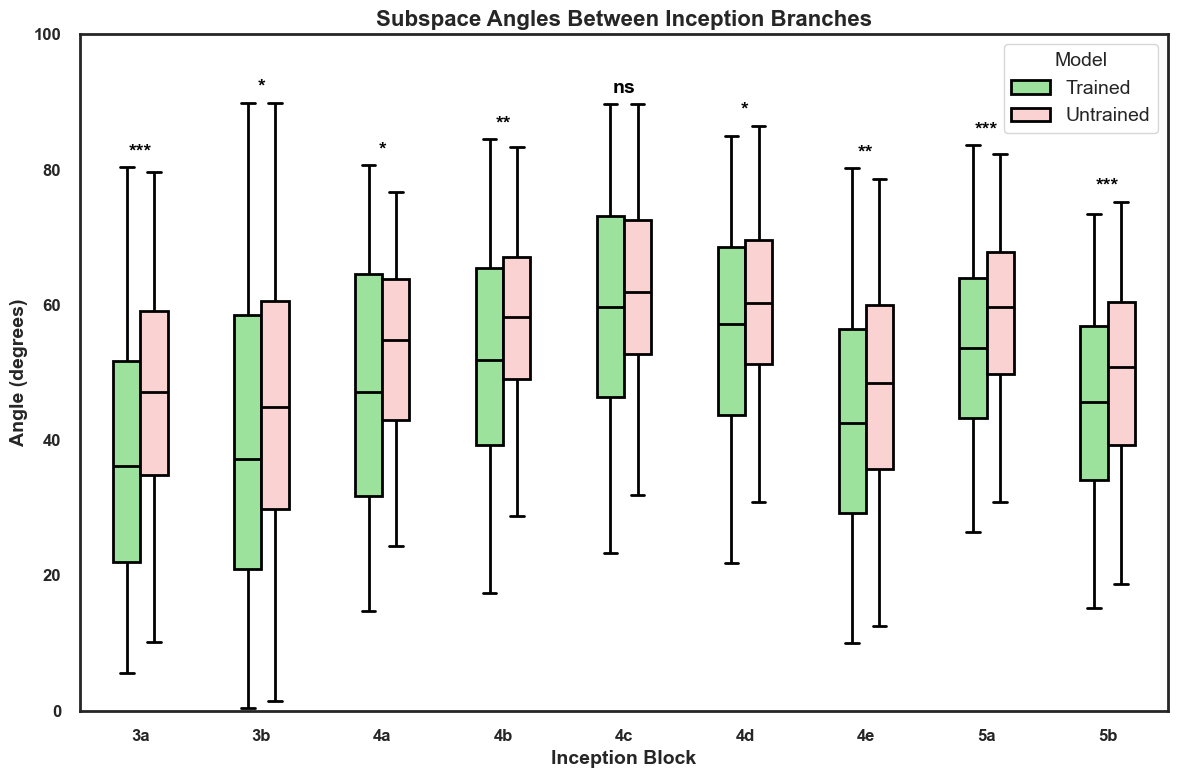

In [15]:
# Function to test normality and compare angles
def test_normality_and_compare(trained_angles, untrained_angles):
    # Test for normality
    stat_trained, p_trained = shapiro(trained_angles)
    stat_untrained, p_untrained = shapiro(untrained_angles)
    
    if p_trained > 0.05 and p_untrained > 0.05:
        # Both datasets are normally distributed
        t_stat, p_value = ttest_ind(trained_angles, untrained_angles, equal_var=False)
        test_name = "Welch's t-test"
    else:
        # At least one dataset is not normally distributed
        u_stat, p_value = mannwhitneyu(trained_angles, untrained_angles)
        test_name = "Mann-Whitney U test"
    
    return test_name, p_value

# Collect p-values for each module
p_values = {}
for module_name in angles_trained_dict.keys():
    trained_angles = np.concatenate(angles_trained_dict[module_name])
    untrained_angles = np.concatenate(angles_untrained_dict[module_name])
    
    _, p_value = test_normality_and_compare(trained_angles, untrained_angles)
    p_values[module_name] = p_value

# Create a DataFrame to store the data
# Prepare the data for the boxplot
trained_data = []
untrained_data = []
trained_module_names = []
untrained_module_names = []

for module_name, angles in angles_trained_dict.items():
    flat_angles = np.concatenate(angles)
    trained_data.extend(flat_angles)
    trained_module_names.extend([module_name] * len(flat_angles))

for module_name, angles in angles_untrained_dict.items():
    flat_angles = np.concatenate(angles)
    untrained_data.extend(flat_angles)
    untrained_module_names.extend([module_name] * len(flat_angles))

# Create a DataFrame for easier plotting with seaborn
data = pd.DataFrame({
    'Angle (degrees)': trained_data + untrained_data,
    'Model': ['Trained'] * len(trained_data) + ['Untrained'] * len(untrained_data),
    'Module': trained_module_names + untrained_module_names
})



# Plot
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(12, 8))

# Create the boxplot with seaborn
sns.boxplot(x='Module', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.45, palette=face_palette, ax=ax)

# Customize the plot
plt.title('Subspace Angles Between Inception Branches', weight='bold')
plt.ylabel('Angle (degrees)', weight='bold')
plt.xlabel('Inception Block', weight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
# modifty the x-ticks so they don't say inception
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['3a', '3b', '4a', '4b', '4c', '4d', '4e', '5a', '5b'])
plt.legend(title='Model')
plt.ylim(0, 100)

# Annotate significance
def add_stat_annotation(ax, x, y, data, hue, p_values, test_name):
    # Get the unique modules
    modules = data[x].unique()
    y_max = data[y].max()
    
    for module in modules:
        # Calculate positions for annotations
        trained_data = data[(data[x] == module) & (data[hue] == 'Trained')][y]
        untrained_data = data[(data[x] == module) & (data[hue] == 'Untrained')][y]
        y_min, y_max_trained = trained_data.min(), trained_data.max()
        y_min_untrained, y_max_untrained = untrained_data.min(), untrained_data.max()
        y_max_plot = max(y_max_trained, y_max_untrained)
        
        # Retrieve the p-value
        p_value = p_values[module]
        
        # Determine annotation text
        if p_value < 0.001:
            annotation = '***'
        elif p_value < 0.01:
            annotation = '**'
        elif p_value < 0.05:
            annotation = '*'
        else:
            annotation = 'ns'
        
        # Add the annotation
        ax.text(modules.tolist().index(module), y_max_plot + 0.01*y_max, annotation, 
                ha='center', va='bottom', color='black', fontsize=14, weight='bold')

# Add statistical annotations
add_stat_annotation(ax, 'Module', 'Angle (degrees)', data, 'Model', p_values, test_name='')

plt.tight_layout()
plt.show()


In [16]:
# Define the branches of interest
branches = ['branch1', 'branch2', 'branch3']

# Extract and flatten weights for each Inception module
inception_modules = ['inception3a', 'inception3b', 'inception4a', 'inception4b', 'inception4c', 'inception4d', 'inception4e', 'inception5a', 'inception5b']
all_weights_trained = {}
all_weights_untrained = {}

for module_name in inception_modules:
    module = getattr(googlenet, module_name)
    all_weights_trained[module_name] = extract_and_flatten_weights(module, branches)
    module_untrained = getattr(googlenet_untrained, module_name)
    all_weights_untrained[module_name] = extract_and_flatten_weights(module_untrained, branches)

# Perform SVD on the flattened weights and compute subspace angles
subspace_angles_trained = {}
subspace_angles_untrained = {}

for module_name, weights in all_weights_trained.items():
    # Perform SVD on the trained weights
    U1, S1, V1 = np.linalg.svd(weights['branch1'], full_matrices=False)
    U2, S2, V2 = np.linalg.svd(weights['branch2'], full_matrices=False)
    U3, S3, V3 = np.linalg.svd(weights['branch3'], full_matrices=False)
    V1 = V1.T
    V2 = V2.T
    V3 = V3.T

    # Perform SVD on the untrained weights
    weights_untrained = all_weights_untrained[module_name]
    U1_untrained, S1_untrained, V1_untrained = np.linalg.svd(weights_untrained['branch1'], full_matrices=False)
    U2_untrained, S2_untrained, V2_untrained = np.linalg.svd(weights_untrained['branch2'], full_matrices=False)
    U3_untrained, S3_untrained, V3_untrained = np.linalg.svd(weights_untrained['branch3'], full_matrices=False)
    V1_untrained = V1_untrained.T
    V2_untrained = V2_untrained.T
    V3_untrained = V3_untrained.T

    # Compute subspace angles for trained
    subspace_angles_trained[module_name] = {
        'V1-V2': subspace_angles_function(V1, V2),
        'V2-V3': subspace_angles_function(V2, V3),
        'V1-V3': subspace_angles_function(V1, V3)
    }

    # Compute subspace angles for untrained
    subspace_angles_untrained[module_name] = {
        'V1-V2': subspace_angles_function(V1_untrained, V2_untrained),
        'V2-V3': subspace_angles_function(V2_untrained, V3_untrained),
        'V1-V3': subspace_angles_function(V1_untrained, V3_untrained)
    }



In [17]:
# # Directory where pickle files will be stored
# pickle_folder = 'pickle'

# # Ensure the pickle folder exists, create if it doesn't
# os.makedirs(pickle_folder, exist_ok=True)

# # Save trained and untrained angles dictionaries to pickle files in the pickle folder
# with open(os.path.join(pickle_folder, 'trained_angles_inception_branches_all.pkl'), 'wb') as f:
#     pickle.dump(subspace_angles_trained, f)

# with open(os.path.join(pickle_folder, 'untrained_angles_inception_branches_all.pkl'), 'wb') as f:
#     pickle.dump(subspace_angles_untrained, f)

In [18]:
# Directory where pickle files are stored
pickle_folder = 'pickle'

# Load trained and untrained angles dictionaries from pickle files in the pickle folder
with open(os.path.join(pickle_folder, 'trained_angles_inception_branches_all.pkl'), 'rb') as f:
    angles_trained_dict = pickle.load(f)

with open(os.path.join(pickle_folder, 'untrained_angles_inception_branches_all.pkl'), 'rb') as f:
    angles_untrained_dict = pickle.load(f)

In [19]:
# Customize the x-tick labels
xtick_labels = ['3a V1-V2', '3a V2-V3', '3a V1-V3',
                '3b V1-V2', '3b V2-V3', '3b V1-V3',
                '4a V1-V2', '4a V2-V3', '4a V1-V3',
                '4b V1-V2', '4b V2-V3', '4b V1-V3',
                '4c V1-V2', '4c V2-V3', '4c V1-V3',
                '4d V1-V2', '4d V2-V3', '4d V1-V3',
                '4e V1-V2', '4e V2-V3', '4e V1-V3',
                '5a V1-V2', '5a V2-V3', '5a V1-V3',
                '5b V1-V2', '5b V2-V3', '5b V1-V3']

In [20]:
# Prepare the data for the boxplot
trained_data = []
untrained_data = []
angle_pairs = []
module_names = []

for module_name in inception_modules:
    for pair in ['V1-V2', 'V2-V3', 'V1-V3']:
        trained_data.extend(angles_trained_dict[module_name][pair])
        untrained_data.extend(angles_untrained_dict[module_name][pair])
        angle_pairs.extend([pair] * len(angles_trained_dict[module_name][pair]))
        module_names.extend([module_name + ' ' + pair] * len(angles_untrained_dict[module_name][pair]))

# Create a DataFrame for easier plotting with seaborn
data = pd.DataFrame({
    'Angle (degrees)': trained_data + untrained_data,
    'Model': ['Trained'] * len(trained_data) + ['Untrained'] * len(untrained_data),
    'Module-Pair': module_names + module_names,
})




/var/folders/nl/b1m_65ld6zz9h49v1d93ysxh0000gn/T/ipykernel_5295/2373842215.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontweight='bold')


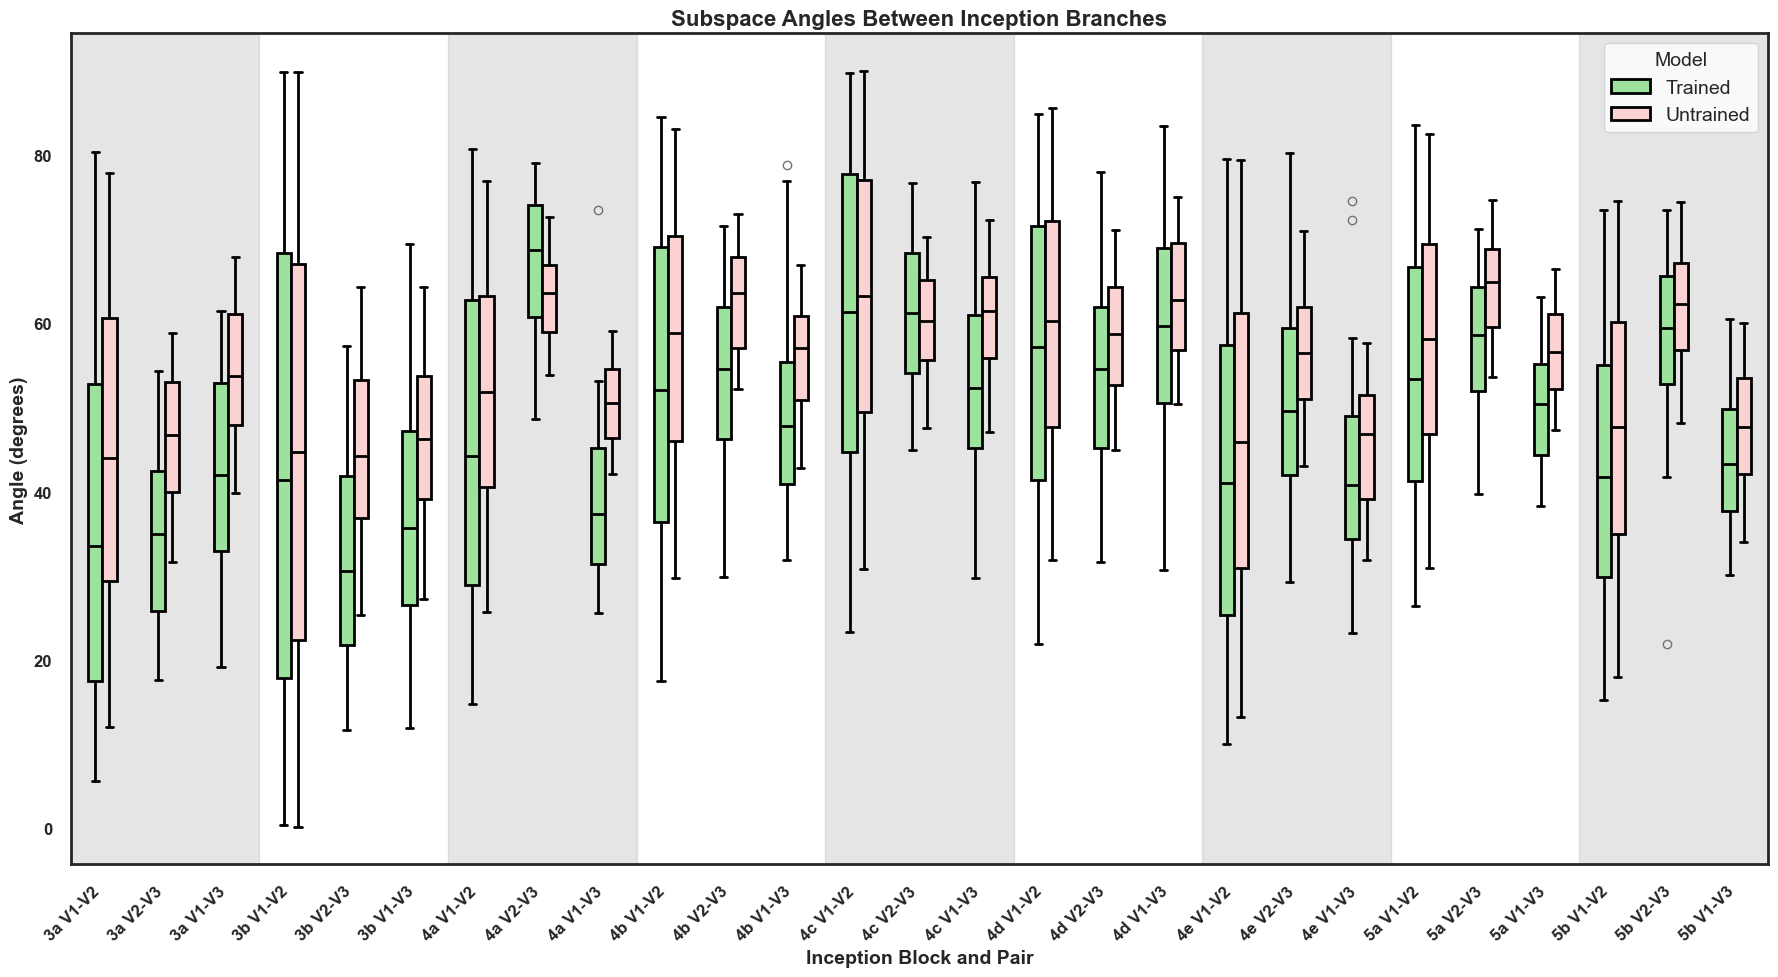

In [21]:
# Plot
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(18, 10))  # Adjusted size for better visibility

# Alternate background shading
for i in range(0, len(xtick_labels), 3):
    ax.axvspan(i - 0.5, i + 2.5, color='grey', alpha=0.2 if i // 3 % 2 == 0 else 0.0)

# Create the boxplot with seaborn
sns.boxplot(x='Module-Pair', y='Angle (degrees)', hue='Model', data=data,
            boxprops={'edgecolor': 'k', 'linewidth': 2}, 
            medianprops={'color': 'k', 'linewidth': 2}, 
            whiskerprops={'color': 'k', 'linewidth': 2}, 
            capprops={'color': 'k', 'linewidth': 2}, 
            width=0.45, palette=face_palette, ax=ax)

# Customize the x-tick labels
ax.set_xticklabels(xtick_labels, rotation=45, ha='right', fontweight='bold')

# Customize the plot
plt.title('Subspace Angles Between Inception Branches', weight='bold')
plt.ylabel('Angle (degrees)', weight='bold')
plt.xlabel('Inception Block and Pair', weight='bold')
plt.yticks(fontweight='bold')
plt.legend(title='Model')
plt.tight_layout()

plt.show()